# Simple Model Comparison - One Sample T-Test

_Author: Šimon Kucharský_

In this notebook, we will show how to do a simple model comparison in BayesFlow amortized over the number of observations.

Amortized Bayesian model comparison leverages neural networks to learn a mapping from data to posterior model probabilities, effectively bypassing the need for costly inference procedures for each new dataset. This method is particularly useful in scenarios where model evaluation needs to be performed repeatedly, as the inference cost is front-loaded into the training phase, enabling rapid comparisons at test time.

In [2]:
import numpy as np

import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"
    
import keras
import bayesflow as bf

## Simulator

First we define our simulators, one for every model that we want to compare. In this notebook, we will use two simple models

$$
\begin{aligned}
\mathcal{M}_0: \mu & = 0 \\
\mathcal{M}_1: \mu & \sim \text{Normal}(0, 1) \\ 
\\
n & \sim \text{Uniform}(10, 100) \\
x_i & \sim \text{Normal}(\mu, 1) \text{ for } i \in \{1, \dots, n \} \\
\end{aligned}
$$

Each model has their own prior but the likelihood (that is responsible for simulating the data $x$) remains the same for both models.

Once we define the two simulators, we wrap them in one overarching simulator that simulates from both models at the same time, for the purpose of training the networks from either of the models. Our context variable $n$ is the _sample size_ that we amortize over as is used as a shared simulator for both models, so that data within each simulated batch can consist of simulations from either model, buth with the same sample size.

In [3]:
def context(batch_shape, n=None):
    if n is None:
        n = np.random.randint(5, 50)
    return dict(n = n)

def prior_null():
    return dict(mu = 0.0)

def prior_alternative():
    mu = np.random.normal(loc=0, scale=1)
    return dict(mu = mu)

def likelihood(n, mu):
    x = np.random.normal(loc=mu, scale=1, size=n)
    return dict(x=x)

simulator_null = bf.make_simulator([prior_null, likelihood])
simulator_alternative = bf.make_simulator([prior_alternative, likelihood])
simulator = bf.simulators.ModelComparisonSimulator(
    simulators=[simulator_null, simulator_alternative], 
    use_mixed_batches=True, 
    shared_simulator=context)

Now we can simulate some data to see what the simulator produces.

In [4]:
data = simulator.sample(100)
print("n =", data["n"])
for key, value in data.items():
    print(key + " shape:", np.array(value).shape)

n = 41
n shape: ()
mu shape: (100, 1)
x shape: (100, 41)
model_indices shape: (100, 2)


Notice that the simulator automaticall adds `model_indices`, which indicates which data was generated which model (it is one-hot encoded, therefore will have as many columns as models).

The size of the observations `x` depends on the context variable `n`. 

## Defining the neural networks

To ensure that the training data generated by the simulator can be used for deep learning, we have to do some transformations that will put the data into necessary structures. Here, we will define an `adapter` that takes the data and transforms the input.

In [5]:
adapter = (
    bf.Adapter()
    .broadcast("n", to="x")
    .as_set("x")
    .rename("n", "classifier_conditions")
    .rename("x", "summary_variables")
    .drop('mu')
    )

Here is what the adapter is doing:

- `.broadcast("n", to="x")` copies the value of `n` `batch_size` times to ensure that it will also have a dimension `(batch_size,)` even though during simulations it was just a single value that is constant over all simulations within the batch. The batch size is inferred from the shape of `x`.
- `.as_set("n")` indicates that `x` is treated as a set. Their values will be treated as _exchangeable_, meaning that the inference will be the same regardless of their order. 
- `.rename("n", "classifier_conditions")` to make an inference for model comparison, we need to know the sample size. Here, we make sure that `n` is passed directly into the classification network as its condition.
- `.rename("x", "summary_variables")` the data `x` will be passed through a summary network. The output of the summary network will be automatically concatenated with `classifier_conditions` before passing them together into the classification network.
- `.drop("mu")` drops the parameter values `mu` which are not used during model comparison.

We can now apply the adapter to simulated data to see the results

In [6]:
processed_data=adapter(data)
for key, value in processed_data.items():
    print(key + " shape:", value.shape)

model_indices shape: (100, 2)
classifier_conditions shape: (100, 1)
summary_variables shape: (100, 41, 1)


All those shapes are correct now. To summarise, we have

- `model_indices`: The indicators of which model produced the data (one-hot encoded)
- `classifier_conditions`: `n` repeated `batch_size` times
- `summary_variables`: The observations `x` with shape `(100, n, 1)`. The last axis is added by `as_set` such that it can be passed into a summary network

Now we can finally define our networks. 

As a summary network, we will use a simple deep set architecture which is appropriate for summarising exchangeable data. 

As a classification network, we will use a simple multilayer perceptron with 8 hidden layers, each with 32 neurons and ReLU activation function.

In [7]:
summary_network = bf.networks.DeepSet(summary_dim=4, dropout=0.0)
classifier_network = keras.Sequential(
    [keras.layers.Dense(32, activation="relu") for _ in range(8)]
    )

We can now define our `approximator` consisting of the two networks and the adapter defined above.

In [8]:
approximator = bf.approximators.ModelComparisonApproximator(
    num_models=2, 
    classifier_network=classifier_network,
    summary_network=summary_network, 
    adapter=adapter)

## Training

Now we are ready to train our approximator that will alow us to compare the two models.

To achieve this, we will define a bunch of parameters that indicate how long and on how much data we want the train the models.

In [9]:
num_batches = 64
batch_size = 512
epochs = 20

Then, we define our optimizer, and specify a schedule for its learning rate. In here, we use a `CosineDecay` schedule for `Adam` optimizer.

In [10]:
learning_rate = keras.optimizers.schedules.CosineDecay(1e-4, decay_steps=epochs*num_batches, alpha=1e-5)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
approximator.compile(optimizer=optimizer)

And we can fit the networks now!

In [11]:
history = approximator.fit(
    epochs=epochs,
    num_batches=num_batches,
    batch_size=batch_size,
    simulator=simulator,
    adapter=adapter
)

INFO:bayesflow:Building dataset from simulator instance of ModelComparisonSimulator.
INFO:bayesflow:Using 10 data loading workers.
INFO:bayesflow:Building on a test batch.


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 718ms/step - loss: 0.6690 - loss/classifier_loss: 0.6690
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - loss: 0.5315 - loss/classifier_loss: 0.5315
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.4293 - loss/classifier_loss: 0.4293
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.4099 - loss/classifier_loss: 0.4099
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.3929 - loss/classifier_loss: 0.3929
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.4036 - loss/classifier_loss: 0.4036
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.4066 - loss/classifier_loss: 0.4066
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.3983 - loss/classifier_loss: 0.3983
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.4059 - loss/classifier_loss: 0.4059
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.4010 - loss/classifier_loss: 0.4010
Epoch 11/20
64/64 ━━━━━━

Once training is done, we can visualise the losses.

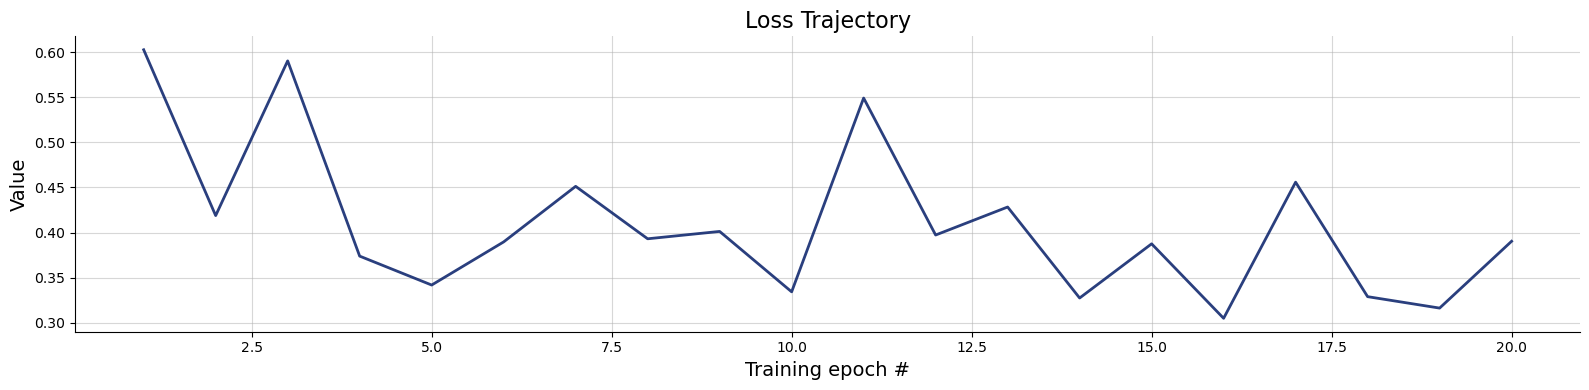

In [12]:
f=bf.diagnostics.plots.loss(history=history)

## Validation

Once we trained the model, we can inspect whether the classification does what we expect it to do.

Here, we will generate a validation dataset which has been fixed to generate data of _sample size_ $n=10$. 

In [13]:
df=simulator.sample(5000, n=10)
print(df["n"])
print(df["x"].shape)

10
(5000, 10)


To apply our approximator on this dataset, we simply use the `.predict` method to obtain the predicted posterior model probabilities, given the data and the approximator.

In [14]:
pred_models=approximator.predict(conditions=df)

We inspect the model comparison calibration now.

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode


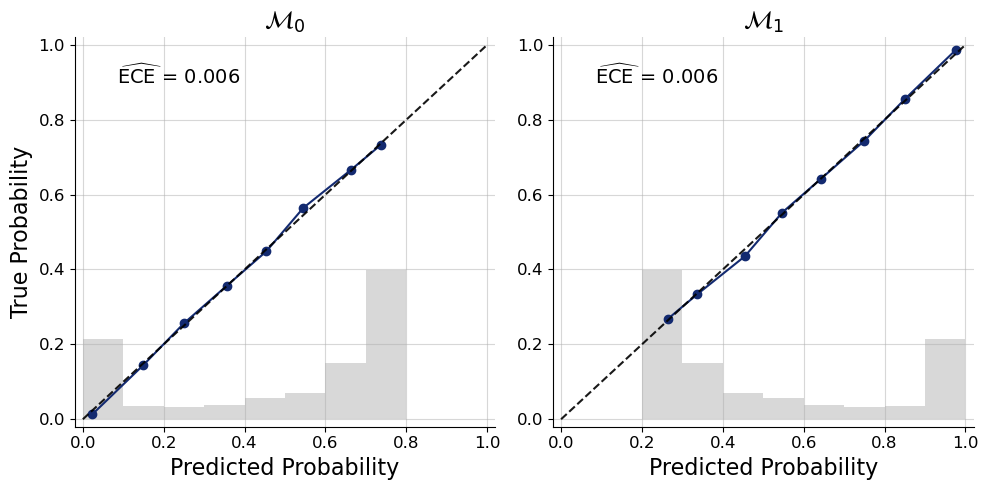

In [15]:
f=bf.diagnostics.plots.mc_calibration(
    pred_models=pred_models, 
    true_models=df["model_indices"],
    model_names=[r"$\mathcal{M}_0$",r"$\mathcal{M}_1$"])

And the confusion matrix to inspect how often we would make an accurate decision based on picking the model with the highest posterior probability.

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode


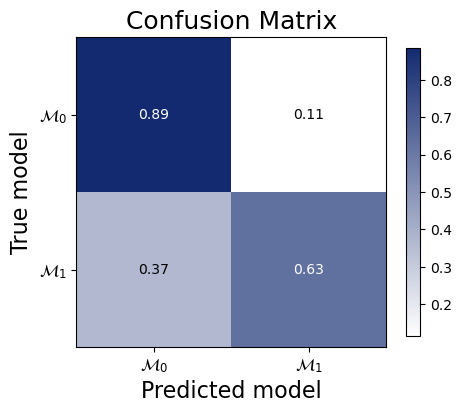

In [16]:
f=bf.diagnostics.plots.mc_confusion_matrix(
    pred_models=pred_models, 
    true_models=df['model_indices'], 
    model_names=[r"$\mathcal{M}_0$",r"$\mathcal{M}_1$"],
    normalize="true")